In [1]:
%pip install qiskit pylatexenc


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=26a5cd95af896b88dcbc3a48687cf7abdf249b15a558cbf90778fb2d6db0b9f0
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


In [2]:
pip install qiskit-aer --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 27.6 MB/s eta 0:00:00


# Algebraic Normal Form of a Boolean Function

Let $f(x):\{0,1\}^n \mapsto \{0,1\}$ be a Boolean function. Then its ANF is a way to express $f(x)$ as
\begin{align*}
f(x) =& a_0 \oplus \\
&a_1x_1\oplus \dots \oplus a_nx_n\oplus \\
&a_{1,2} x_1x_2  \oplus \dots \oplus a_{n-1,n}x_{n-1}x_n\oplus \\
&\dots \oplus\\
&a_{1,\dots,n}x_1\dots x_n
\end{align*}
where each $a_0,a_1,\dots,a_{1,\dots,n}\in\{0,1\}$.

# Circuit for $|x\rangle |y \rangle \mapsto |x\rangle | f(x) \oplus y\rangle$.

Consider the following picture

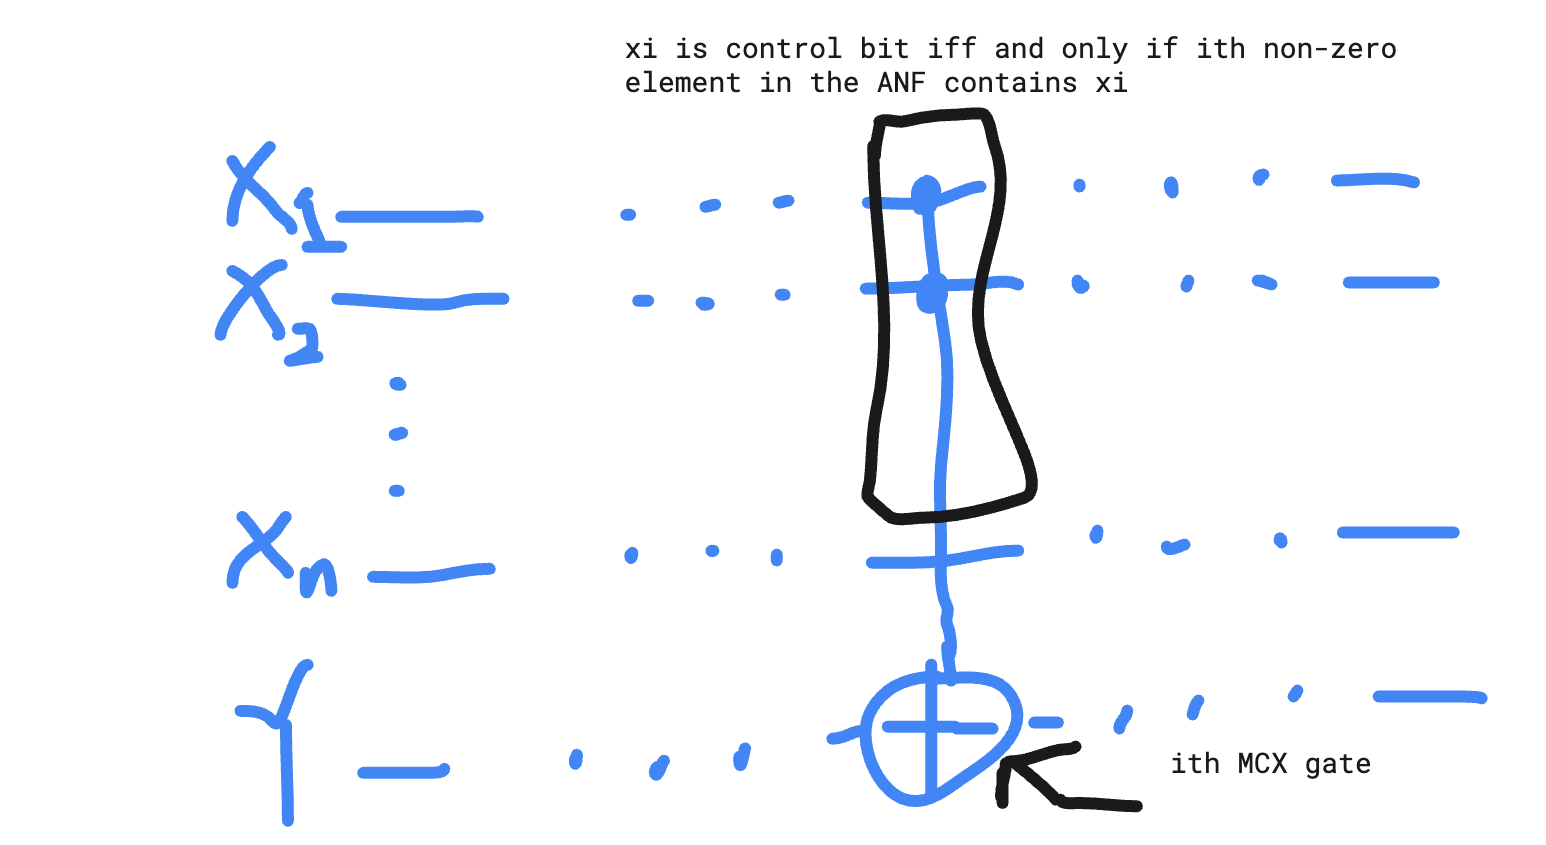

Suppose ANF for $f(x)$ can be written
\begin{align*}
f(x) = \sum_{i\in I} \prod_{j\in S_i}x_j
\end{align*}
where $I$ and  $S_i$ are some index sets. Then we associate every set $S_i$ a MCX gate, the ith MCX gate, as follows.

The target bit of ith MCX gate is Y. The control bits of ith MCX gate are the set of $x_j$ such that $x_j\in S_i$.  Let's analyze the correctness of the circuit next.

If   $x_j=1$ for all $x_j\in S_i$, then this MCX gate is "activated" and the target bit is applied an X gate, i.e. $|\text{target bit}\rangle \mapsto |\text{target bit}\oplus 1\rangle$.


If   $x_j=0$ for some $x_j\in S_i$, then identity map is applied to the target bit, i.e. $|\text{target bit}\rangle \mapsto |\text{target bit}\oplus 0\rangle$.

Combining gives $|\text{target bit}\rangle \mapsto |\text{target bit}\oplus \prod_{j\in S_i}x_j \rangle$.

Now for each $S_i$, it is associated with such a MCX gate. Therefore, we get
$$
|y\rangle \mapsto |y\oplus \sum_{i\in I}\oplus \prod_{j\in S_i}x_j \rangle=|y\oplus f(x)\rangle
$$


# Computation of ANF

ANF of $f(x)$ is computed by appying Walsh-Hadamard transform on the truth table (written in terms of a vector in $\{0,1\}^{ \text{len} (x) }$) of $f(x)$.

Reference: Chapter 2.2, Proposition 8, page 67 of Boolean Functions for Cryptography and Coding Theory (link: https://www.math.univ-paris13.fr/~carlet/book-fcts-Bool-vect-crypt-codes.pdf)




In [3]:
import inspect
from scipy.linalg import hadamard

from qiskit_aer import AerSimulator


from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, Parameter
from qiskit.circuit.library import UGate
from qiskit.quantum_info import Statevector, Operator
import numpy as np
import sys

from itertools import product
from typing import Callable, List
import math

# Compute Truth table of f(x)
def compute_truth_table(f: Callable[..., int],n) -> List[int]:
  #print("n",n)
  ret = np.zeros(2 ** n).astype(bool)
  i = 0
  for x in product((0, 1), repeat=n):
    ret[i] = bool(f(*x))
    i += 1
  return ret


# Convert the data structure of ANF into a convenient one
def convert_bit_ANF_to_list_ANF(bit_ANF, n):
  monomials = []
  for S, a in enumerate(bit_ANF):
    if a:                                   # coefficient 1
      indicator = [int(bool(S & (1 << i))) for i in range(n)]
      monomials.append(indicator)

  # optional: sort nicely (constant, linears, quadratics, …)
  monomials.sort(key=lambda v: (sum(v), v))
  ret = np.array(monomials, dtype = int)
  return ret

# Walsh-Hadamard transform to compute ANF
def compute_ANF(truth_table,n):
  tt = [int(bool(b)) for b in truth_table]
  #print(len(truth_table))
  #print(math.log2(len(truth_table)))
  #print(n)

  # Hadamard transform of truth table of f. It is proved that the output is the ANF of f.
  coeff = tt[:]

  for i in range(n):                      # broadcast *one bit* per pass
    bit = 1 << i
    for S in range(1 << n):             # all subsets
      if S & bit:                     # supersets that contain this bit
          coeff[S] ^= coeff[S ^ bit]  # accumulate from immediate ancestor

  #for S in range(1 << n):
  #  for i in range(n):
  #    indicator_xi = 1 << i
  #    if S & indicator_xi:                    # i ∈ S
  #      coeff[S] ^= coeff[S ^ indicator_xi]   # S ^ indicator_xi is associated with a smaller set (in size),
                                              # and the loop will go from smaller set to larger ones. Therefore,
                                              # the update will not cause error.
  # The above part ouputs coeff as an ANF of f, but the data structure of it is not so easily readable
  # Therefore, convert_bit_ANF_to_list_ANF is used to convert it into the result in an np 2d array
  return convert_bit_ANF_to_list_ANF(coeff, n)


# Build the circuit.
def quantum_boolean_circuit(f):


  n = len(inspect.signature(f).parameters)
  table = compute_truth_table(f,n)
  anf = compute_ANF(table,n)
  m, _ = anf.shape

  input_qubits = QuantumRegister(size=n, name="x")
  quantum_circuit = QuantumCircuit(input_qubits, name="Boolean Funcion Circuit")
  output_qubit = QuantumRegister(size=1, name="y")
  quantum_circuit.add_register(output_qubit)
  #ancilla_qubits = AncillaRegister(size=m, name=f"ancilla")
  #quantum_circuit.add_register(ancilla_qubits)

  for i in range(m):
    monomial = anf[i]
    control_bits = []

    #print("monomial",monomial)
    for j in range(n):
      if monomial[j] == 1:
        #print("j",j)
        control_bits.append(input_qubits[j])
    #control_bits = [input_qubits[np.argwhere(monomial == 1)]]
    target = output_qubit

    if len(control_bits) == 0:                      # constant term 1
        quantum_circuit.x(target)                      # flip to |1⟩
    elif len(control_bits) == 1:              # degree-1 term xi
        quantum_circuit.cx(control_bits[0], target)
    else:                                 # degree ≥2  (AND of several xi's)
        quantum_circuit.mcx(control_bits, target)
  #quantum_circuit.draw(output="mpl")
  #control_bits = [ancilla_qubits]
  #target_bit = output_qubit
  #quantum_circuit.mcx(ancilla_qubits, output_qubit)



  return quantum_circuit.to_gate()






# Build the circuit, but it is not of form a gate. we keep this version so that
# when using circuit.draw() method, we can see a clear structure of the circuit
def quantum_boolean_circuit_no_to_gate(f):


  n = len(inspect.signature(f).parameters)
  table = compute_truth_table(f,n)
  anf = compute_ANF(table,n)
  m, _ = anf.shape

  input_qubits = QuantumRegister(size=n, name="x")
  quantum_circuit = QuantumCircuit(input_qubits, name="Boolean Funcion Circuit")
  output_qubit = QuantumRegister(size=1, name="y")
  quantum_circuit.add_register(output_qubit)
  #ancilla_qubits = AncillaRegister(size=m, name=f"ancilla")
  #quantum_circuit.add_register(ancilla_qubits)

  for i in range(m):
    monomial = anf[i]
    control_bits = []

    #print("monomial",monomial)
    for j in range(n):
      if monomial[j] == 1:
        #print("j",j)
        control_bits.append(input_qubits[j])
    #control_bits = [input_qubits[np.argwhere(monomial == 1)]]
    target = output_qubit

    if len(control_bits) == 0:                      # constant term 1
        quantum_circuit.x(target)                      # flip to |1⟩
    elif len(control_bits) == 1:              # degree-1 term xi
        quantum_circuit.cx(control_bits[0], target)
    else:                                 # degree ≥2  (AND of several xi's)
        quantum_circuit.mcx(control_bits, target)
  #quantum_circuit.draw(output="mpl")
  #control_bits = [ancilla_qubits]
  #target_bit = output_qubit
  #quantum_circuit.mcx(ancilla_qubits, output_qubit)


  return (quantum_circuit, input_qubits, output_qubit)





# Benchmark

## First Example

The first example we give is the function
$$
f(x) =   x_0\lor  x_1
$$
We point out that suppose we write $x_i =1$ if $x_i=\text{True}$, $x_i =0$ if $x_i=\text{False}$. Then we can write
$$
f(x) = \text{truth value of }\Big ((x_0 + x_1) >= 1\Big )
$$
ANF of $f(x)$
$$
f(x) = x_0\oplus x_1 \oplus x_0x_1
$$



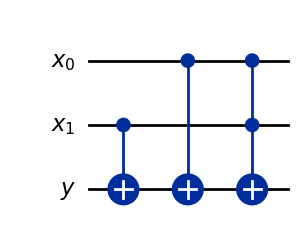

In [4]:
# Example Boolean function on 2 bits: majority
f = lambda x1, x2: (x1 + x2) >= 1
(circuit, x_bits, y_bits) = quantum_boolean_circuit_no_to_gate(f)
circuit.draw(output="mpl")

In [5]:
n=2
truth_table = compute_truth_table(f,n)

anf = compute_ANF(truth_table,n)
m, _ = anf.shape
U_f_circuit = quantum_boolean_circuit(f)





print(" x  | f(x)   | y_out")
print("---------------------")

for idx in range(2**n):
    # --- Prepare |x〉|0〉 ------------------------------------
    bits = [(idx >> k) & 1 for k in range(n)]      # LSB first
    x = QuantumRegister(size=n, name="x")
    y = QuantumRegister(size=1, name="y")
    #ancilla = AncillaRegister(size=m, name="ancilla")
    qc = QuantumCircuit(x, y)
    for qubit, bit in enumerate(bits):
        if bit:
            qc.x(qubit)
    #print(Statevector(qc).probabilities())

    # --- Apply oracle and simulate with Statevector ----------
    qc.barrier()
    qc.compose(U_f_circuit, inplace=True)
    sv = Statevector.from_instruction(qc)          # fast for ≤ 8 qubits

    # Find the basis state that has probability 1 (deterministic oracle)
    basis_index = max(range(2**(n + 1)),
                      key=lambda k: abs(sv.data[k])**2)

    # Convert the index to a bit-string with (n+1) bits, MSB = qubit-0
    bitstring = format(basis_index, f"0{n+1}b")
    y_out = int(bitstring[0])                     # y is the LAST qubit

    # --- Pretty print result -------------------------------
    print(f" {''.join(map(str,bits[::-1]))}    {int(truth_table[idx])}        {y_out}"
          + ("     ✓" if y_out == truth_table[idx] else "     ✗"))

 x  | f(x)   | y_out
---------------------
 00    0        0     ✓
 01    1        1     ✓
 10    1        1     ✓
 11    1        1     ✓


## Second Example

The Second example we give is the function
$$
f(x) =   x_2\lor  (x_0 x_1)
$$
Suppose we write $x_i =1$ if $x_i=\text{True}$, $x_i =0$ if $x_i=\text{False}$. Then we can write
$$
f(x) = \text{truth value of }\Big ((x_2 + x_0x_1) >= 1\Big )
$$
ANF of $f(x)$
$$
f(x) = x_2\oplus x_0x_1 \oplus x_0x_1x_2
$$


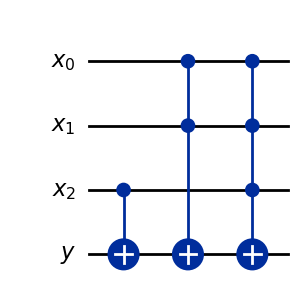

In [8]:

f = lambda x1, x2, x3: (x1 + x2 * x3) >= 1
(circuit, x_bits, y_bits) = quantum_boolean_circuit_no_to_gate(f)
circuit.draw(output="mpl")

In [6]:

n = 3
f = lambda x1, x2, x3: (x1 + x2 * x3) >= 1
truth_table = compute_truth_table(f,n)

anf = compute_ANF(truth_table,n)
m, _ = anf.shape
U_f_circuit = quantum_boolean_circuit(f)





print(" x  | f(x)   | y_out")
print("---------------------")

for idx in range(2**n):
    # --- Prepare |x〉|0〉 ------------------------------------
    bits = [(idx >> k) & 1 for k in range(n)]      # LSB first
    x = QuantumRegister(size=n, name="x")
    y = QuantumRegister(size=1, name="y")
    #ancilla = AncillaRegister(size=m, name="ancilla")
    qc = QuantumCircuit(x, y)
    for qubit, bit in enumerate(bits):
        if bit:
            qc.x(qubit)
    #print(Statevector(qc).probabilities())

    # --- Apply oracle and simulate with Statevector ----------
    qc.barrier()
    qc.compose(U_f_circuit, inplace=True)
    sv = Statevector.from_instruction(qc)          # fast for ≤ 8 qubits

    # Find the basis state that has probability 1 (deterministic oracle)
    basis_index = max(range(2**(n + 1)),
                      key=lambda k: abs(sv.data[k])**2)

    # Convert the index to a bit-string with (n+1) bits, MSB = qubit-0
    bitstring = format(basis_index, f"0{n+1}b")
    y_out = int(bitstring[0])                     # y is the LAST qubit

    # --- Pretty print result -------------------------------
    print(f" {''.join(map(str,bits[::-1]))}    {int(truth_table[idx])}        {y_out}"
          + ("     ✓" if y_out == truth_table[idx] else "     ✗"))

 x  | f(x)   | y_out
---------------------
 000    0        0     ✓
 001    0        0     ✓
 010    0        0     ✓
 011    1        1     ✓
 100    1        1     ✓
 101    1        1     ✓
 110    1        1     ✓
 111    1        1     ✓
